A notebook for the analysis of skyrmions and target states in hexagonal islands with different applied field, hexagon size and boundary conditions.

# Imports and definitions

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
plt.style.use('lato_style.mplstyle')

import fidimag
import sim_from_image as sfi
import os, re
import fidimag.common.constant as C
from fidimag.atomistic import UniformExchange, DMI, Anisotropy, DemagHexagonal
from fidimag.atomistic import Zeeman

import colorsys
from cycler import cycler

import sys
sys.path.append('mesh_geometries')
from sim_geometries import TruncatedTriangleSim, HexagonSim

# -----------------------------------------------------------------------------

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) / 255.
                 for i in range(0, lv, lv // 3))

# -----------------------------------------------------------------------------

# Colour palettes for the curves (used in cycle
d_palette2 = ['29376E', 'F52A00', 'F79400', '245723', 'DE2600']
d_palette1 = ['2C4C8F', 'FF5814', '88B459', 'D91D2C', '8F5536',
              '542437', '6F6F6F']

# Turn it into a palette readable by matplotlib
d_palette2 = [hex_to_rgb(c) for c in d_palette2]
d_palette1 = [hex_to_rgb(c) for c in d_palette1]

# Loading data

Function to create a simulation for different circumradius $R$ and field $B$

In [2]:
def create_simulation(R, B, pin_bs=False):
    mu_s = 3
    sim_hexagon = HexagonSim(R,       # R
                             0.2715,  # a
                             mu_s,    # mu_s
                             name='unnamed'
                             )
    sim = sim_hexagon.sim

    mask = (sim.mu_s / C.mu_B) > 1e-5
    exch = UniformExchange(5.881 * C.meV)
    sim.add(exch)
    dmi = DMI(D=1.557 * C.meV, dmi_type='interfacial')
    sim.add(dmi)
    sim.add(Zeeman([0., 0., B]))
    sim.add(Anisotropy(0.406 * C.meV, axis=[0, 0, 1]))
    
    # -------------------------------------------------------------------------

    if pin_bs:
        # We will correct the spin directions according to the specified argument,
        # in case the spins at the boundaries are pinned
        boundary_spins = np.logical_and(np.any(sim.mesh.neighbours < 0, axis=1),
                                        sim.mu_s != 0)

        new_m = np.copy(sim.spin.reshape(-1, 3))
        new_m[boundary_spins] = np.array([pin_bs[0], pin_bs[1],pin_bs[2]])
        sim.set_m(new_m.reshape(-1,))

        # Now we pin the spins:
        ngbs_filter = np.zeros(sim.pins.shape[0])
        # Filter rows by checking if any of the elements is less than zero
        # This means that if any of the neighbours of the i-th lattice site is
        # -1, we pin the spin direction at that site
        ngbs_filter = np.any(sim.mesh.neighbours < 0, axis=1, out=ngbs_filter)
        sim.set_pins(ngbs_filter)
    
    # -------------------------------------------------------------------------

    return sim

Load the data for hexagons of different $R$ and applied field $B$. We load the energy of the FM ordering, skyrmions and target states. We shift all the energies with respect to the energy of a fully polarised state in the $+z$ direction:

In [10]:
base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
# base_folder = 'hexagonal_system/relaxation/hexagons_size_variation_minimiser/npys/'

B_range = range(0, 2001, 100)

# Dictionaries to save the energies for different R and B for every configuration
hexagons_tgt_st = {}
hexagons_sk_down = {}
hexagons_fm_up = {}

# for i, R in enumerate(range(4, 21, 2)):
for i, R in enumerate(list(range(4, 21, 2)) + [24, 28]):
    
    hexagons_tgt_st[R] = np.zeros((len(B_range), 2))
    hexagons_sk_down[R] = np.zeros((len(B_range), 2))
    hexagons_fm_up[R] = np.zeros((len(B_range), 2))
    
    for j, B in enumerate(B_range):
        
        sim = create_simulation(R, B * 1e-3)
        
        # ---------------------------------------------------------------------

        fmsim = create_simulation(R, B * 1e-3, pin_bs=False)
        # fmsim.set_m(np.load(base_folder + fname + npy_file))
        fmsim.set_m((0, 0, 1))
        
        fm_sim_energy = fmsim.compute_energy()
        
        # ---------------------------------------------------------------------
        # ferromagnetic up energy (tilted spins rim)

        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_fm-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        # sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_fm_up[R][j, 0] = B * 1e-3
        hexagons_fm_up[R][j, 1] = (sim.compute_energy()
                                   - fm_sim_energy
                                    ) / C.eV
        
        # ---------------------------------------------------------------------
        # Target state energy
        
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_tgt_st[R][j, 0] = B * 1e-3
        hexagons_tgt_st[R][j, 1] = (sim.compute_energy()
                                    - fm_sim_energy
                                    ) / C.eV
        
        # ---------------------------------------------------------------------
        # skyrmion up energy
        
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        # sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_down[R][j, 0] = B * 1e-3
        hexagons_sk_down[R][j, 1] = (sim.compute_energy()
                                    - fm_sim_energy
                                    ) / C.eV

The same when using a FM rim. Notice that the FM ordering is equivalent to the fully polarised state with this boundary condition:

In [4]:
base_folder = '../simulations/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
# B = -1500
B_range = range(0, 2001, 100)

hexagons_tgt_st_pinbs = {}
hexagons_sk_down_pinbs = {}
hexagons_fm_up_pinbs = {}


for i, R in enumerate(list(range(4, 21, 2)) + [24, 28]):
    
    hexagons_tgt_st_pinbs[R] = np.zeros((len(B_range), 2))
    hexagons_sk_down_pinbs[R] = np.zeros((len(B_range), 2))
    hexagons_fm_up_pinbs[R] = np.zeros((len(B_range), 2))
    
    for j, B in enumerate(B_range):
        
        sim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        
        # ---------------------------------------------------------------------
        
        fmsim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        # fmsim.set_m(np.load(base_folder + fname + npy_file))
        fmsim.set_m((0, 0, 1))
        fm_sim_energy = fmsim.compute_energy()
        
        # ---------------------------------------------------------------------
              
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_tgt_st_pinbs[R][j, 0] = B * 1e-3
        hexagons_tgt_st_pinbs[R][j, 1] = (sim.compute_energy()
                                          - fm_sim_energy
                                          ) / C.eV
        
        # ---------------------------------------------------------------------
        
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_down_pinbs[R][j, 0] = B * 1e-3
        hexagons_sk_down_pinbs[R][j, 1] = (sim.compute_energy()
                                           - fm_sim_energy
                                           ) / C.eV
        
        # ---------------------------------------------------------------------
        # ferromagnetic up energy (this should always be zero)

        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_fm-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        # sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_fm_up_pinbs[R][j, 0] = B * 1e-3
        hexagons_fm_up_pinbs[R][j, 1] = (sim.compute_energy()
                                         - fm_sim_energy
                                         ) / C.eV

Comaprison of pinned and unpinned rims

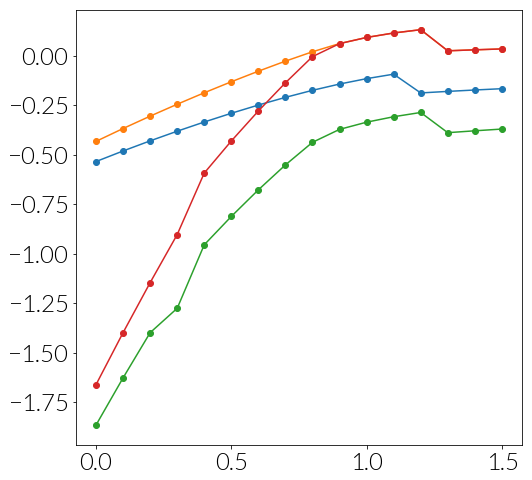

In [198]:
plt.plot(hexagons_tgt_st[10][:, 0], 
             hexagons_tgt_st[10][:, 1], 'o-')

plt.plot(hexagons_tgt_st_pinbs[10][:, 0], 
             hexagons_tgt_st_pinbs[10][:, 1], 'o-')

plt.plot(hexagons_tgt_st[20][:, 0], 
             hexagons_tgt_st[20][:, 1], 'o-')

plt.plot(hexagons_tgt_st_pinbs[20][:, 0], 
             hexagons_tgt_st_pinbs[20][:, 1], 'o-')

# Target State

## Snaphots

Load data to plot snapshots of the target states. We do this by loading the realxed states into Fidimag simulations

In [5]:
base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
# B = -1500
B_range = range(0, 1401, 200)

hexagons_tgt_st_m = {}

for i, R in enumerate(range(20, 21, 2)):
    
    hexagons_tgt_st_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=None)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_tgt_st_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

# -----------------------------------------------------------------------------
        
base_folder = 'hexagonal_system/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
# B = -1500
B_range = range(0, 1401, 200)

hexagons_tgt_st_pbs_m = {}

for i, R in enumerate(range(20, 21, 2)):
    
    hexagons_tgt_st_pbs_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_tgt_st_pbs_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

# Energy plot of target states

We plot the energy of skyrmions and target states as a function of applied field for different hexagon sizes and boundary conditions. Snapshots with the relaxed configurations are shown below the corresponding plots with different boundary conditions.

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


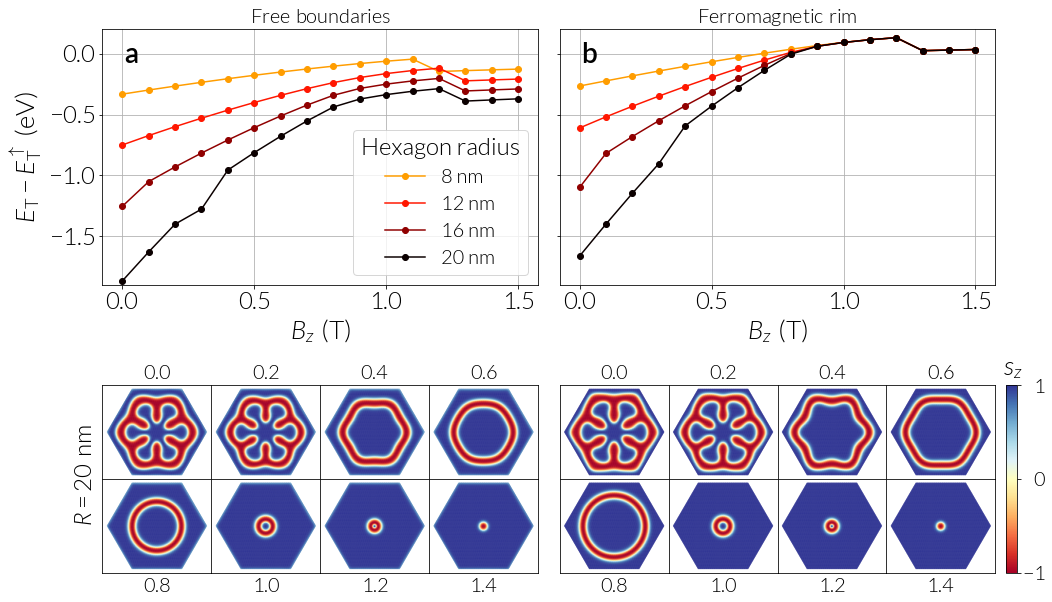

In [58]:
mask = (sim.mu_s / C.mu_B) > 1e-5

f = plt.figure(figsize=(16, 8/1.6 + 8/1.6))
axs = [None] * 22
# Make outer gridspec
outer = gridspec.GridSpec(2, 2,
                          height_ratios = [3, 2.2]
                          )
# Separation of the bottom row of plots from the top grid
# outer.update(hspace=0.15)
outer.update(wspace=0.05)
outer.update(hspace=0.45)

# Make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 0],
                                       hspace=0, wspace=0
                                       )
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 1],
                                       hspace=0, wspace=0
                                       )
gs3 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 0], hspace=0, wspace=0)
gs4 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 1], hspace=0, wspace=0)

# Axes:
axs[0] = plt.subplot(gs1[:1, :4])
axs[1] = plt.subplot(gs2[:1, :4])
axs[1].set_yticklabels([])

for i, j in enumerate(range(2, 6)):
    axs[j] = plt.subplot(gs3[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(6, 10)):
    axs[j] = plt.subplot(gs3[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
    
for i, j in enumerate(range(10, 14)):
    axs[j] = plt.subplot(gs4[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(14, 18)):
    axs[j] = plt.subplot(gs4[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])

# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
cm_subsection = np.linspace(0.4, 1, 4) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]
# -----------------------------------------------------------------------------
# The energy of target states in islands with free boundaries
# Remember that energies were computed with respect to the fully polarised state
for i, R in enumerate(range(8, 21, 4)):
    axs[0].plot(hexagons_tgt_st[R][:, 0], 
                hexagons_tgt_st[R][:, 1], 
                'o-', c=cm_colors[i], label=r'{} nm'.format(R))
axs[0].grid()
axs[0].set_ylim([-1.9, 0.2])
axs[0].set_ylabel(r'$E_{\mathrm{T}} - E_{\mathrm{T}}^{\uparrow}\,\,\mathrm{(eV)}$')
axs[0].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')

axs[0].legend(title=r'Hexagon radius', fontsize=20)

axs[0].set_title(r'$\mathrm{Free}\,\,\mathrm{boundaries}$', fontsize=20)

axs[0].text(0.05, 0.95, 'a', horizontalalignment='left',
            verticalalignment='top', transform=axs[0].transAxes, 
            fontsize=28, fontweight='bold')
# -----------------------------------------------------------------------------
# The energies for islands with a ferromagnetic rim
for i, R in enumerate(range(8, 21, 4)):
    axs[1].plot(hexagons_tgt_st_pinbs[R][:, 0], 
                hexagons_tgt_st_pinbs[R][:, 1], 'o-', c=cm_colors[i])
axs[1].grid()
axs[1].set_ylim([-1.9, 0.2])
axs[1].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
axs[1].set_title(r'$\mathrm{Ferromagnetic}\,\,\mathrm{rim}$', fontsize=20)

axs[1].text(0.05, 0.95, 'b', horizontalalignment='left',
            verticalalignment='top', transform=axs[1].transAxes, 
            fontsize=28, fontweight='bold')
# -----------------------------------------------------------------------------
B_range = range(0, 1401, 200)
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]
sim = create_simulation(20, 1400 * 1e-3, pin_bs=(0, 0, -1))
mask = (sim.mu_s / C.mu_B) > 1e-5

# -----------------------------------------------------------------------------
# Snapshots of the relaxed configurations using scatter plots
for i, j in enumerate(range(2, 10)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_tgt_st_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)
        
    if i == 0:
        axs[j].text(-0.25, -0.5, r'$R=20\,\,\mathrm{nm}$', 
                    horizontalalignment='left', rotation=90,
                    verticalalignment='bottom', transform=axs[j].transAxes, 
                    fontsize=24)
# -----------------------------------------------------------------------------
# snapshots for the system with FM rim
for i, j in enumerate(range(10, 18)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_tgt_st_pbs_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)
        
    if i == 3:
        # create color bar
        box = axs[j].get_position()
        axColor = plt.axes([box.x0 * 1.01 + box.width * 1.01, 
                            box.y0 - box.height, 0.01, 2 * box.height])
        cb = plt.colorbar(axs[j].get_children()[0], cax=axColor, orientation="vertical")
        cb.set_ticks([-1, 0, 1])
        ticklabs = cb.ax.get_yticklabels()
        cb.ax.set_yticklabels(ticklabs, ha='right', fontsize=20)
        cb.ax.yaxis.set_tick_params(pad=25)
        
        cb.set_label(r'$s_{z}$', rotation=0, labelpad=-33, y=1.15)       

plt.savefig('hexagons_size_variation_2PI-vortex-up.pdf',
            bbox_inches='tight')
# plt.savefig('hexagons_size_variation_2PI-vortex.jpg', density=200,
#             bbox_inches='tight')

## Energy per atom:

The same plot but using the energy scaled per spin:

8 2611
12 5852
16 10384
20 16207


/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


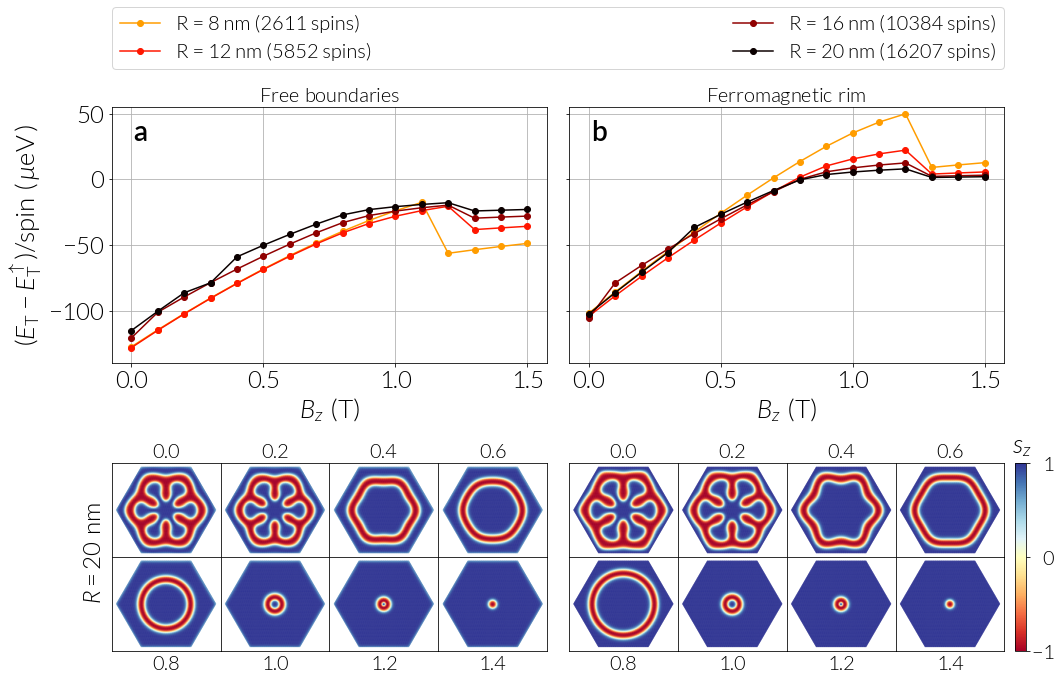

In [59]:
mask = (sim.mu_s / C.mu_B) > 1e-5

f = plt.figure(figsize=(16, 8/1.6 + 8/1.6))
axs = [None] * 22
# Make outer gridspec
outer = gridspec.GridSpec(2, 2,
                          height_ratios = [3, 2.2]
                          )
# Separation of the bottom row of plots from the top grid
# outer.update(hspace=0.15)
outer.update(wspace=0.05)
outer.update(hspace=0.45)

# Make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 0],
                                       hspace=0, wspace=0
                                       )
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 1],
                                       hspace=0, wspace=0
                                       )
gs3 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 0], hspace=0, wspace=0)
gs4 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 1], hspace=0, wspace=0)

# Axes:
axs[0] = plt.subplot(gs1[:1, :4])
axs[1] = plt.subplot(gs2[:1, :4])
axs[1].set_yticklabels([])

for i, j in enumerate(range(2, 6)):
    axs[j] = plt.subplot(gs3[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(6, 10)):
    axs[j] = plt.subplot(gs3[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
    
for i, j in enumerate(range(10, 14)):
    axs[j] = plt.subplot(gs4[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(14, 18)):
    axs[j] = plt.subplot(gs4[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])

# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
cm_subsection = np.linspace(0.4, 1, 4) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]
# -----------------------------------------------------------------------------
for i, R in enumerate(range(8, 21, 4)):
    sim = create_simulation(R, B * 1e-3, pin_bs=None)
    n_atoms = len(sim.mesh.coordinates[:, 0][sim.mu_s / C.mu_B > 1e-5])
    axs[0].plot(hexagons_tgt_st[R][:, 0], 
                1e6 * hexagons_tgt_st[R][:, 1] / n_atoms, 
                'o-', c=cm_colors[i], 
                label=r'R = {} nm ({} spins)'.format(R, n_atoms)
                )
axs[0].grid()
axs[0].set_ylim([-140, 55])
axs[0].set_ylabel(r'$(E_{\mathrm{T}} - E_{\mathrm{T}}^{\uparrow})/\mathrm{spin}\,\,(\,\mu\mathrm{eV}\,)$')
axs[0].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')

# Legend
# axs[0].legend(title=r'Hexagon radius', fontsize=20)
axs[0].legend(ncol=2, loc='lower left', bbox_to_anchor=(0, 1.15, 2.05, 1),
              mode='expand', borderaxespad=0., fontsize=20,
              )


axs[0].set_title(r'$\mathrm{Free}\,\,\mathrm{boundaries}$', fontsize=20)

axs[0].text(0.05, 0.85, 'a', horizontalalignment='left',
            verticalalignment='bottom', transform=axs[0].transAxes, 
            fontsize=28, fontweight='bold')
# -----------------------------------------------------------------------------
for i, R in enumerate(range(8, 21, 4)):
    sim = create_simulation(R, B * 1e-3, pin_bs=None)
    n_atoms = len(sim.mesh.coordinates[:, 0][sim.mu_s / C.mu_B > 1e-5])
    print(R, n_atoms)
    axs[1].plot(hexagons_tgt_st_pinbs[R][:, 0], 
                1e6 * hexagons_tgt_st_pinbs[R][:, 1] / n_atoms,
                'o-', c=cm_colors[i])
axs[1].grid()
axs[1].set_ylim([-140, 55])
axs[1].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
axs[1].set_title(r'$\mathrm{Ferromagnetic}\,\,\mathrm{rim}$', fontsize=20)

axs[1].text(0.05, 0.85, 'b', horizontalalignment='left',
            verticalalignment='bottom', transform=axs[1].transAxes, 
            fontsize=28, fontweight='bold')
# -----------------------------------------------------------------------------
B_range = range(0, 1401, 200)
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]
sim = create_simulation(20, 1400 * 1e-3, pin_bs=(0, 0, -1))
mask = (sim.mu_s / C.mu_B) > 1e-5

# -----------------------------------------------------------------------------
for i, j in enumerate(range(2, 10)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_tgt_st_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)
        
    if i == 0:
        axs[j].text(-0.25, -0.5, r'$R=20\,\,\mathrm{nm}$', 
                    horizontalalignment='left', rotation=90,
                    verticalalignment='bottom', transform=axs[j].transAxes, 
                    fontsize=24)
# -----------------------------------------------------------------------------
for i, j in enumerate(range(10, 18)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_tgt_st_pbs_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)
        
    if i == 3:
        # create color bar
        box = axs[j].get_position()
        axColor = plt.axes([box.x0 * 1.01 + box.width * 1.01, 
                            box.y0 - box.height, 0.01, 2 * box.height])
        cb = plt.colorbar(axs[j].get_children()[0], cax=axColor, orientation="vertical")
        cb.set_ticks([-1, 0, 1])
        ticklabs = cb.ax.get_yticklabels()
        cb.ax.set_yticklabels(ticklabs, ha='right', fontsize=20)
        cb.ax.yaxis.set_tick_params(pad=25)
        
        cb.set_label(r'$s_{z}$', rotation=0, labelpad=-33, y=1.15)       

plt.savefig('hexagons_size_variation_2PI-vortex-up_per-spin.pdf',
            bbox_inches='tight')
# plt.savefig('hexagons_size_variation_2PI-vortex.jpg', density=200,
#             bbox_inches='tight')

## Snapshots for different R

Snapshots of the system with variable island size:

In [454]:
base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
# B = -1500
B_range = range(0, 1, 200)

hexagons_tgt_st_m = {}

for i, R in enumerate(range(4, 21, 4)):
    
    # hexagons_tgt_st_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        mask = (sim.mu_s / C.mu_B) > 1e-5
        hexagons_tgt_st_m[R] = [np.copy(sim.mesh.coordinates[:, 0])[mask],
                                np.copy(sim.mesh.coordinates[:, 1])[mask],
                                np.copy(sim.spin.reshape(-1, 3)[:, 2])[mask]]

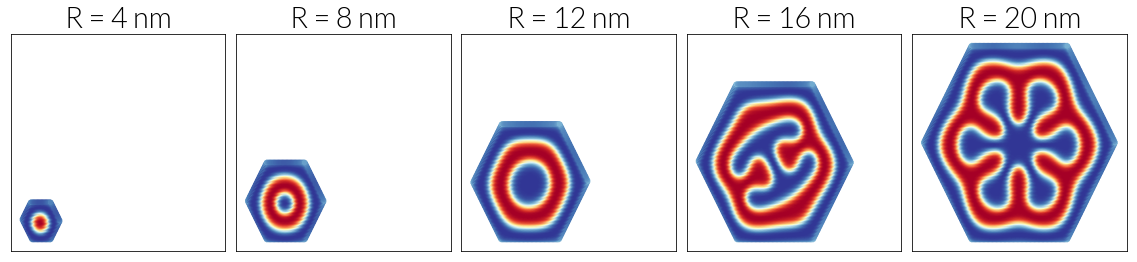

In [455]:
# R = 12
f, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 4))
for i, j in enumerate(range(4, 21, 4)):      
    ax = axs.flatten()[i]
    ax.scatter(hexagons_tgt_st_m[j][0], hexagons_tgt_st_m[j][1], 
               c=hexagons_tgt_st_m[j][2], s=25, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
               )
    ax.set_title('R = {} nm'.format(j), fontweight='light')
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(hspace=0.1, wspace=0.05)

plt.savefig('hexagons_size_variation_2PI-vortex-up_zero-field_snapshots.jpg', dpi=200,
            bbox_inches='tight')

## Snapshots for negative fields

### Free boundaries

In [435]:
base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
# B = -1500
B_range = range(0, -2001, -200)

hexagons_sk_m = {}

for i, R in enumerate([8, 20]):
    
    hexagons_sk_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

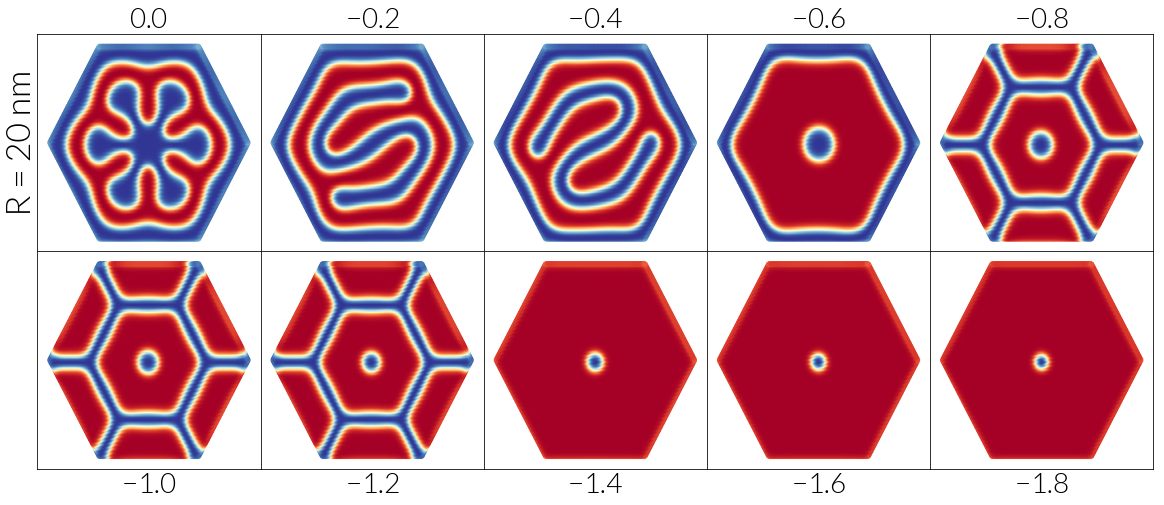

In [437]:
R = 20
sim = create_simulation(R, 0 * 1e-3)
mask = (sim.mu_s / C.mu_B) > 1e-5
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]

f, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20, 8))
for i, j in enumerate(range(0, 10)):      
    ax = axs.flatten()[i]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=hexagons_sk_m[R][j][mask], s=25, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
                   )
    ax.set_xticks([])
    ax.set_yticks([])

    if i < 5:
        ax.set_title(snaps_titles[i], fontsize=28)
    else:
        ax.set_xlabel(snaps_titles[i], fontsize=28)
        
    if i == 0:
        ax.text(-0.135, 0.5, 'R = 20 nm', horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes, 
                fontsize=34, rotation=90)

f.subplots_adjust(hspace=0., wspace=0.0)

plt.savefig('hexagons_R20nm_snapshots_Bz_0-2000mT_tgt-st-up.jpg', 
            dpi=200, bbox_inches='tight')

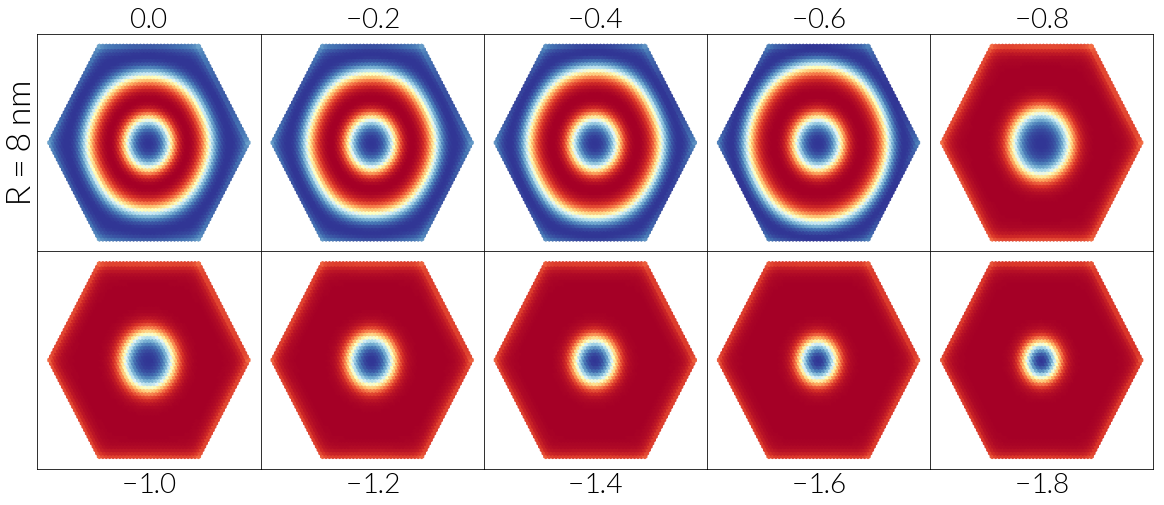

In [438]:
R = 8
sim = create_simulation(R, 0 * 1e-3)
mask = (sim.mu_s / C.mu_B) > 1e-5
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]


f, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20, 8))
for i, j in enumerate(range(0, 10)):      
    ax = axs.flatten()[i]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=hexagons_sk_m[R][j][mask], s=25, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
                   )
    ax.set_xticks([])
    ax.set_yticks([])

    if i < 5:
        ax.set_title(snaps_titles[i], fontsize=28)
    else:
        ax.set_xlabel(snaps_titles[i], fontsize=28)
        
    if i == 0:
        ax.text(-0.135, 0.5, 'R = 8 nm', horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes, 
                fontsize=34, rotation=90)
        
f.subplots_adjust(hspace=0., wspace=0.0)

plt.savefig('hexagons_R8nm_snapshots_Bz_0-2000mT_tgt-st-up.jpg', 
            dpi=200, bbox_inches='tight')

### FM rim

Snapshots for islands with a ferromagnetic rim:

In [61]:
base_folder = '../simulations/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
# B = -1500
B_range = range(0, -2001, -200)

hexagons_sk_m = {}

for i, R in enumerate([20]):
    
    hexagons_sk_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-tgt-st-up_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

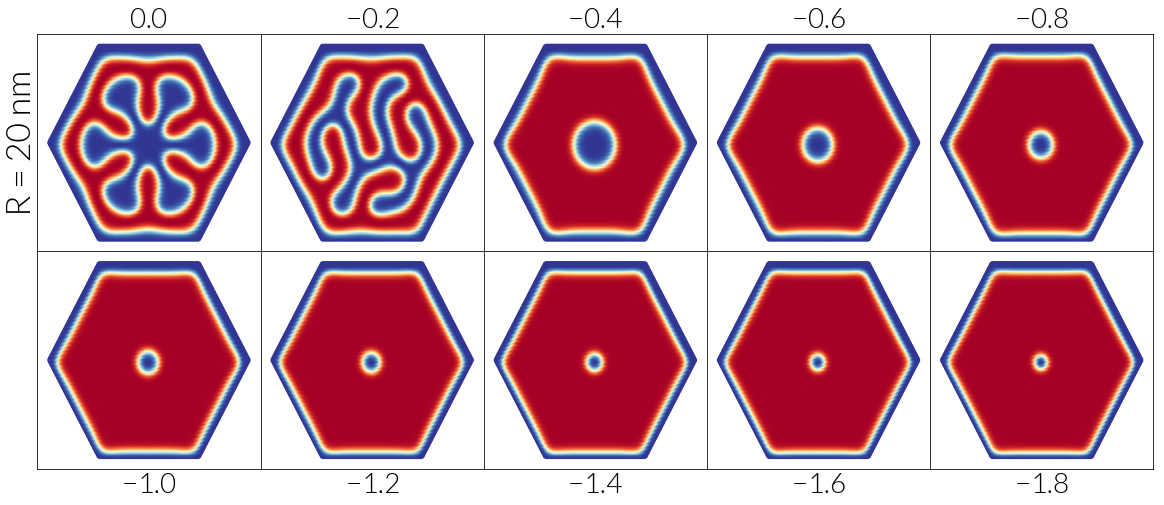

In [62]:
R = 20
sim = create_simulation(R, 0 * 1e-3)
mask = (sim.mu_s / C.mu_B) > 1e-5
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]

f, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20, 8))
for i, j in enumerate(range(0, 10)):      
    ax = axs.flatten()[i]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=hexagons_sk_m[R][j][mask], s=25, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
                   )
    ax.set_xticks([])
    ax.set_yticks([])

    if i < 5:
        ax.set_title(snaps_titles[i], fontsize=28)
    else:
        ax.set_xlabel(snaps_titles[i], fontsize=28)
        
    if i == 0:
        ax.text(-0.135, 0.5, 'R = 20 nm', horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes, 
                fontsize=34, rotation=90)
        
f.subplots_adjust(hspace=0., wspace=0.0)

plt.savefig('hexagons_R20nm_pinned-bs_snapshots_Bz_0-2000mT_tgt-st-up.jpg', 
            dpi=200, bbox_inches='tight')

# Skyrmion Down

## Snaphots

Load data to plot snapshots of the skyrmionic states

In [67]:
base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
# B = -1500
B_range = range(0, 1401, 200)

hexagons_sk_down_m = {}

for i, R in enumerate(range(18, 21, 2)):
    
    hexagons_sk_down_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=None)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_down_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

# -----------------------------------------------------------------------------
        
base_folder = 'hexagonal_system/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
# B = -1500
B_range = range(0, 1401, 200)

hexagons_sk_down_pbs_m = {}

for i, R in enumerate(range(18, 21, 2)):
    
    hexagons_sk_down_pbs_m[R] = []
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        hexagons_sk_down_pbs_m[R].append(np.copy(sim.spin.reshape(-1, 3)[:, 2]))

# Energy plot of skyrmions

Another energy plot but shifting the energy with respect to a fully polarised state (in the $+z$ direction), which we denote by $E_{\uparrow}$

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


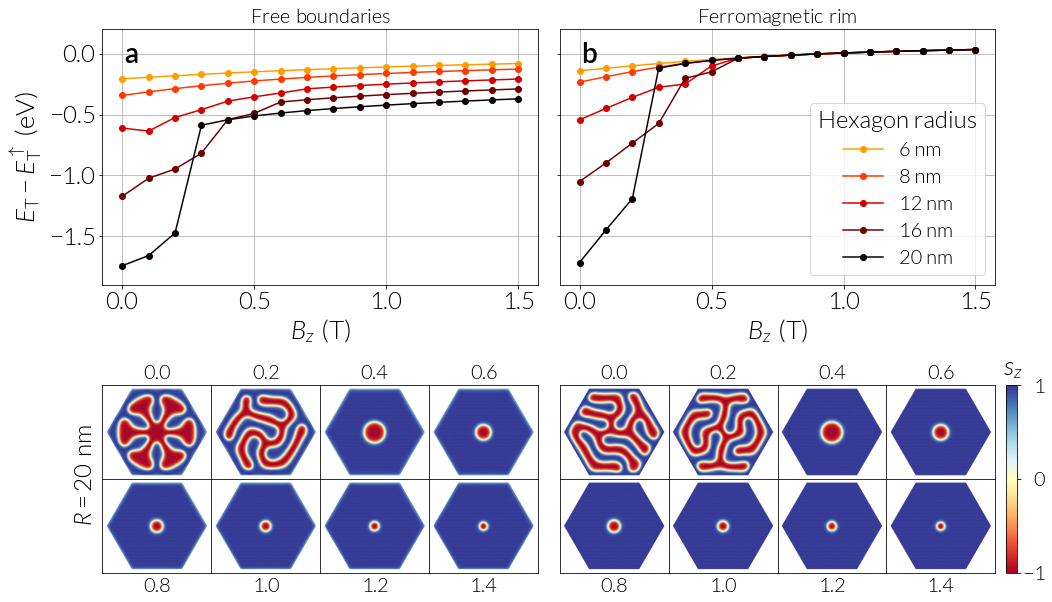

In [82]:
mask = (sim.mu_s / C.mu_B) > 1e-5

f = plt.figure(figsize=(16, 8/1.6 + 8/1.6))
axs = [None] * 22
# Make outer gridspec
outer = gridspec.GridSpec(2, 2,
                          height_ratios = [3, 2.2]
                          )
# Separation of the bottom row of plots from the top grid
# outer.update(hspace=0.15)
outer.update(wspace=0.05)
outer.update(hspace=0.45)

# Make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 0],
                                       hspace=0, wspace=0
                                       )
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[0, 1],
                                       hspace=0, wspace=0
                                       )
gs3 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 0], hspace=0, wspace=0)
gs4 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=outer[1, 1], hspace=0, wspace=0)

# Axes:
axs[0] = plt.subplot(gs1[:1, :4])
axs[1] = plt.subplot(gs2[:1, :4])
axs[1].set_yticklabels([])

for i, j in enumerate(range(2, 6)):
    axs[j] = plt.subplot(gs3[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(6, 10)):
    axs[j] = plt.subplot(gs3[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
    
for i, j in enumerate(range(10, 14)):
    axs[j] = plt.subplot(gs4[0, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])
for i, j in enumerate(range(14, 18)):
    axs[j] = plt.subplot(gs4[1, i])
    axs[j].set_yticks([])
    axs[j].set_xticks([])

# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
R_range = [6] + list(range(8, 21, 4))
cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

# -----------------------------------------------------------------------------
# Energy curves for Free BS

for i, R in enumerate(R_range):
    axs[0].plot(hexagons_sk_down[R][:, 0], 
                hexagons_sk_down[R][:, 1], 
                'o-', c=cm_colors[i], label=r'{} nm'.format(R))
axs[0].grid()
axs[0].set_ylim([-1.9, 0.2])
axs[0].set_ylabel(r'$E_{\mathrm{T}} - E_{\mathrm{T}}^{\uparrow}\,\,\mathrm{(eV)}$')
axs[0].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')

axs[0].set_title(r'$\mathrm{Free}\,\,\mathrm{boundaries}$', fontsize=20)

axs[0].text(0.05, 0.95, 'a', horizontalalignment='left',
            verticalalignment='top', transform=axs[0].transAxes, 
            fontsize=28, fontweight='bold')
# -----------------------------------------------------------------------------
# Energy curves for FM Rim

for i, R in enumerate(R_range):
    axs[1].plot(hexagons_sk_down_pinbs[R][:, 0], 
                hexagons_sk_down_pinbs[R][:, 1], 
                'o-', c=cm_colors[i], label=r'{} nm'.format(R))
axs[1].grid()
axs[1].set_ylim([-1.9, 0.2])
axs[1].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
axs[1].set_title(r'$\mathrm{Ferromagnetic}\,\,\mathrm{rim}$', fontsize=20)

axs[1].text(0.05, 0.95, 'b', horizontalalignment='left',
            verticalalignment='top', transform=axs[1].transAxes, 
            fontsize=28, fontweight='bold')

axs[1].legend(title=r'Hexagon radius', fontsize=20)

# -----------------------------------------------------------------------------
# Create simulation with R=20 for the snapshots
B_range = range(0, 1401, 200)
snaps_titles = [r'$' + '{:.1f}'.format(B * 1e-3) + r'$' 
                for B in B_range]
sim = create_simulation(20, 1400 * 1e-3, pin_bs=(0, 0, -1))
mask = (sim.mu_s / C.mu_B) > 1e-5

# -----------------------------------------------------------------------------
# Snapshots for Free BS
for i, j in enumerate(range(2, 10)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_sk_down_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)
        
    if i == 0:
        axs[j].text(-0.25, -0.5, r'$R=20\,\,\mathrm{nm}$', 
                    horizontalalignment='left', rotation=90,
                    verticalalignment='bottom', transform=axs[j].transAxes, 
                    fontsize=24)
# -----------------------------------------------------------------------------
# Snapshots for FM Rim
for i, j in enumerate(range(10, 18)):      
    axs[j].scatter(sim.mesh.coordinates[:, 0][mask], 
                   sim.mesh.coordinates[:, 1][mask],
                   c=hexagons_sk_down_pbs_m[20][i][mask], s=0.1, marker='h',
                   cmap='RdYlBu', vmin=-1, vmax=1
                   )
    if i < 4:
        axs[j].set_title(snaps_titles[i], fontsize=20)
    else:
        axs[j].set_xlabel(snaps_titles[i], fontsize=20)

    # .........................................................................
    # Colorbar in the FM Rim snapshots plot
    if i == 3:
        # create color bar
        box = axs[j].get_position()
        axColor = plt.axes([box.x0 * 1.01 + box.width * 1.01, 
                            box.y0 - box.height, 0.01, 2 * box.height])
        cb = plt.colorbar(axs[j].get_children()[0], cax=axColor, orientation="vertical")
        cb.set_ticks([-1, 0, 1])
        ticklabs = cb.ax.get_yticklabels()
        cb.ax.set_yticklabels(ticklabs, ha='right', fontsize=20)
        cb.ax.yaxis.set_tick_params(pad=25)
        
        cb.set_label(r'$s_{z}$', rotation=0, labelpad=-33, y=1.15)       

plt.savefig('hexagons_size_variation_sk-down.pdf',
            bbox_inches='tight')
# plt.savefig('hexagons_size_variation_sk-down.jpg', density=200,
#             bbox_inches='tight')

A more detailed view of the nergy of skyrmions in islands with open boundaries:

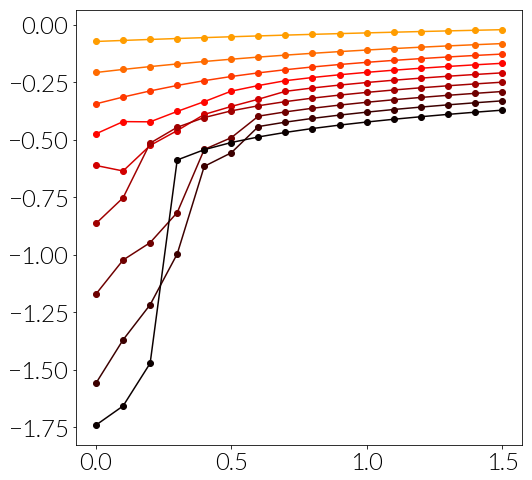

In [76]:
cm_subsection = np.linspace(0.4, 1, 9) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

f = plt.figure()
ax = f.add_subplot(111)

for i, R in enumerate(range(4, 21, 2)):
    ax.plot(hexagons_sk_down[R][:, 0], 
            hexagons_sk_down[R][:, 1], 
            'o-', c=cm_colors[i], label=r'{} nm'.format(R))

# Energy density

We can calculate the energy density of the DMI interaction in the hexagonal islands. To do this we create a Fidimag simulation, load relaxed states into them and compute the DMI energy of the system:

In [7]:
R, B = 8, 1000

base_folder = '../simulations/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
npy_file = os.listdir(base_folder + fname)[0]
sim = create_simulation(R, B * 1e-3)
sim.set_m(np.load(base_folder + fname + npy_file))
sim.compute_effective_field(t=0)
w_dmi_pinbs = sim.get_interaction('DMI').energy

base_folder = 'hexagonal_system/relaxation/hexagons_size_variation_DT/npys/'
fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
npy_file = os.listdir(base_folder + fname)[0]
sim = create_simulation(R, B * 1e-3)
sim.set_m(np.load(base_folder + fname + npy_file))
sim.compute_effective_field(t=0)
w_dmi = sim.get_interaction('DMI').energy

In [53]:
print('Emin =', np.min(w_dmi[mk] / C.meV), 'Emax =', np.max(w_dmi[mk] / C.meV))

Emin = -0.8908010790561557 Emax = -0.06974535106100015


In [54]:
print('Emin =', np.min(w_dmi_pinbs[mk] / C.meV), 'Emax =', np.max(w_dmi_pinbs[mk] / C.meV))

Emin = -0.8763307440920686 Emax = -0.00022406579755343884


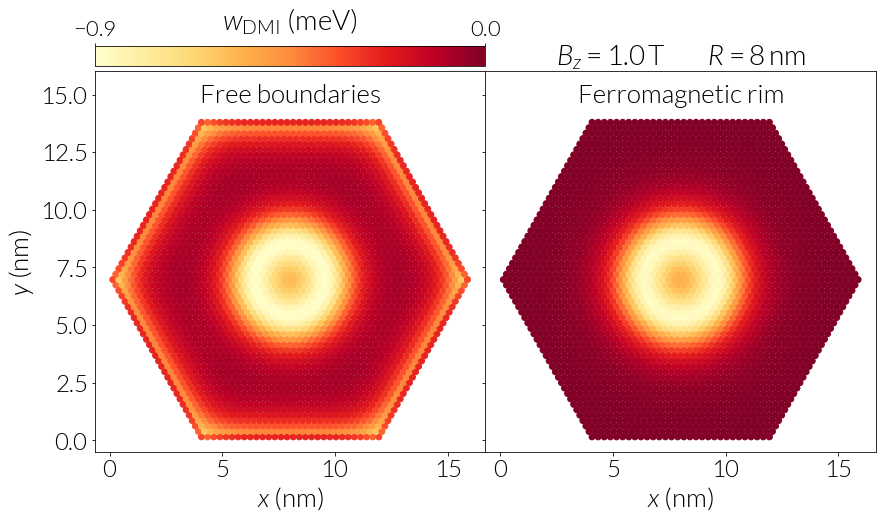

In [111]:
mk = sim.mu_s / C.mu_B > 1e-5
cmap = plt.cm.YlOrRd

f, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 7))

axs[0].scatter(sim.mesh.coordinates[:, 0][mk], sim.mesh.coordinates[:, 1][mk],
            c=w_dmi[mk] / C.meV, cmap=cmap, 
            vmin=-0.9, vmax=0
            )
axs[0].set_xlabel(r'$x$ (nm)')
axs[0].set_ylabel(r'$y$ (nm)')

axs[0].set_ylim(-.5, 16)

axs[0].text(0.5, 0.97, 'Free boundaries', horizontalalignment='center',
            verticalalignment='top', transform=axs[0].transAxes, 
            fontsize=26, fontweight='light')

axs[1].scatter(sim.mesh.coordinates[:, 0][mk], sim.mesh.coordinates[:, 1][mk],
            c=w_dmi_pinbs[mk] / C.meV, cmap=cmap, 
            vmin=-0.9, vmax=0
            )
axs[1].set_xlabel(r'$x$ (nm)')
# axs[1].set_ylabel(r'$y$ (nm)')

axs[1].text(0.5, 0.97, 'Ferromagnetic rim', horizontalalignment='center',
            verticalalignment='top', transform=axs[1].transAxes, 
            fontsize=26, fontweight='light')

plt.subplots_adjust(wspace=0)

# -------------------------------------------------------------------------
box = axs[0].get_position()
axCb = plt.axes([box.x0, box.y1 + 0.01, box.width, 0.04])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap, orientation="horizontal",
                                      ticks=[-0.9, 0],
                                      norm=matplotlib.colors.Normalize(vmin=-0.9, vmax=0))
cb.set_label(r'$w_{\mathrm{DMI}}$ (meV)', rotation=0, x=0.5, labelpad=-60, fontsize=28)
axCb.tick_params(labelsize=22)
axCb.xaxis.set_ticks_position('top')
# -------------------------------------------------------------------------

axs[1].set_title(r'$B_{z}=1.0\,\mathrm{T}\qquad R=8\,\mathrm{nm}$', fontweight='light', fontsize=28)

plt.savefig('hexagons_skyrmion_DMI-energy_R8nm_B1T.pdf', bbox_inches='tight')

## Snapshots at different R

Snapshots of the relaxed states for different applied field and island size:

In [87]:
# B = -1500
B_range = [0, 200, 400, 600]
R_range = [4, 6, 8, 10, 12, 18]

hexagons_sk_m = {}
hexagons_sk_m_pinbs = {}

base_folder = '../simulations/relaxation/hexagons_size_variation_DT/npys/'
for i, R in enumerate(R_range):
    
    hexagons_sk_m[R] = {}
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3)
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        mask = (sim.mu_s / C.mu_B) > 1e-5
        hexagons_sk_m[R][B] = [np.copy(sim.mesh.coordinates[:, 0])[mask],
                               np.copy(sim.mesh.coordinates[:, 1])[mask],
                               np.copy(sim.spin.reshape(-1, 3)[:, 2])[mask]]

base_folder = 'hexagonal_system/relaxation/hexagons_size_variation_pinned_boundary_DT/npys/'
for i, R in enumerate(R_range):
    
    hexagons_sk_m_pinbs[R] = {}
    
    for j, B in enumerate(B_range):
        fname = "2Dhex_hexagon_R{}nm_PdFe-Ir_1-sk-down_B{}mT_npys/".format(R, B)
        npy_file = os.listdir(base_folder + fname)[0]

        sim = create_simulation(R, B * 1e-3, pin_bs=(0, 0, 1))
        sim.set_m(np.load(base_folder + fname + npy_file))
        
        mask = (sim.mu_s / C.mu_B) > 1e-5
        hexagons_sk_m_pinbs[R][B] = [np.copy(sim.mesh.coordinates[:, 0])[mask],
                                     np.copy(sim.mesh.coordinates[:, 1])[mask],
                                     np.copy(sim.spin.reshape(-1, 3)[:, 2])[mask]]

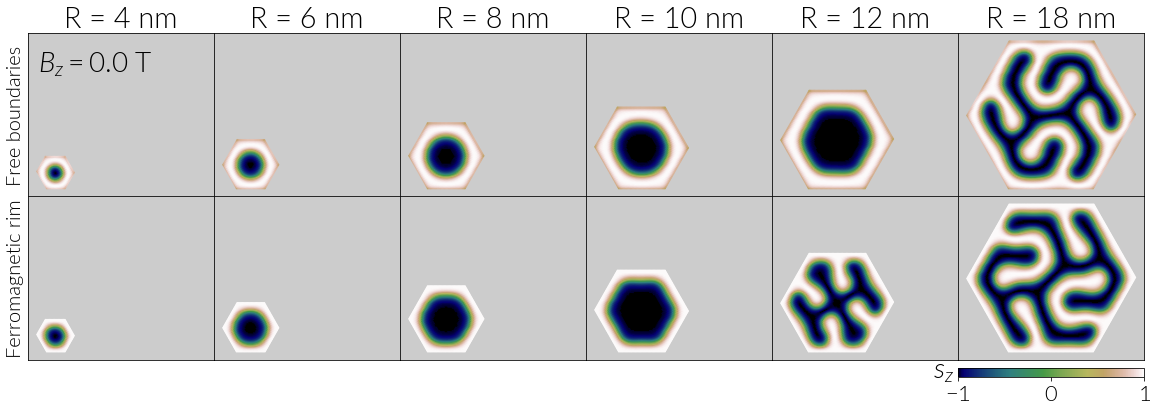

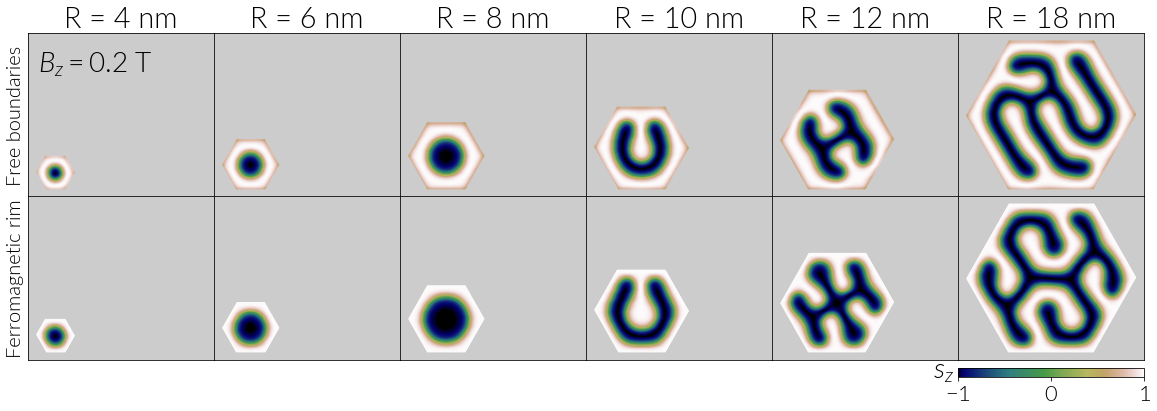

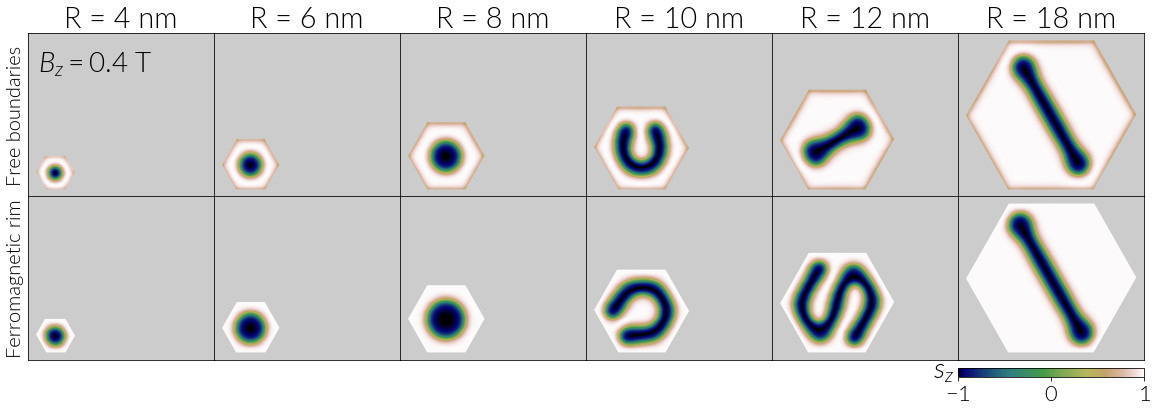

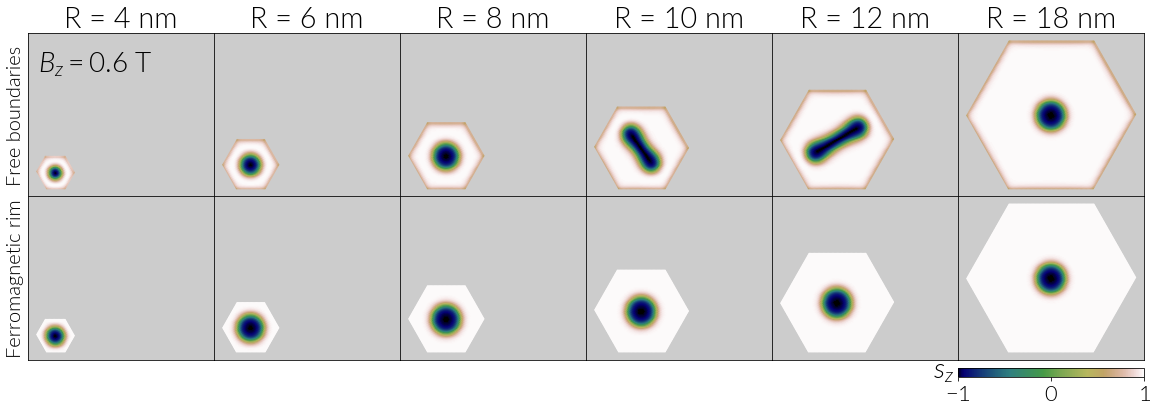

In [89]:
for B in [0, 200, 400, 600]:

    f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(20, 6))
    for i, j in enumerate(R_range):      
        axs[0][i].scatter(hexagons_sk_m[j][B][0], hexagons_sk_m[j][B][1], 
                          c=hexagons_sk_m[j][B][2], s=2, marker='h',
                          cmap='gist_earth', vmin=-1, vmax=1
                          )
        axs[0][i].set_title('R = {} nm'.format(j), fontweight='light')
        axs[0][i].set_xticks([])
        axs[0][i].set_yticks([])
        axs[0][i].set_facecolor((0.8, 0.8, 0.8))

    for i, j in enumerate(R_range):      
        axs[1][i].scatter(hexagons_sk_m_pinbs[j][B][0], hexagons_sk_m_pinbs[j][B][1], 
                          c=hexagons_sk_m_pinbs[j][B][2], s=2, marker='h',
                          cmap='gist_earth', vmin=-1, vmax=1
                          )
        # axs[1][i].set_title('R = {} nm'.format(j), fontweight='light')
        axs[1][i].set_xticks([])
        axs[1][i].set_yticks([])
        axs[1][i].set_facecolor((0.8, 0.8, 0.8))

    axs[0][0].set_ylabel('Free boundaries', fontsize=20)
    axs[1][0].set_ylabel('Ferromagnetic rim', fontsize=20)

    f.subplots_adjust(hspace=0., wspace=0.0)

    # ------------------------------------
    cmap = plt.cm.gist_earth
    box = axs[1][5].get_position()
    axCb = plt.axes([box.x0, box.y0 - 0.04, box.width, 0.02])
    cb = matplotlib.colorbar.ColorbarBase(axCb, plt.cm.gist_earth, orientation="horizontal",
                                  ticks=[-1, 0, 1],
                                  norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
    cb.set_label(r'$s_{z}$', rotation=0, x=-0.08, labelpad=-45, fontsize=28)
    axCb.tick_params(labelsize=22)
    axCb.xaxis.set_ticks_position('bottom')
    # ------------------------------------
    
    axs[0][0].text(0.05, 0.9, r'$B_z=$' + '{:.1f} T'.format(B * 1e-3),
            horizontalalignment='left',
            verticalalignment='top',
            transform=axs[0][0].transAxes,
            fontsize=28)

    plt.savefig('hexagons_size_variation_sk-down_B{}mT_snaps.jpg'.format(B), dpi=200,
                bbox_inches='tight')

# Ferromagnetic state and skyrmion energy

Energy of the ferromagnetic configuration and skyrmions for different boundary conditions. With free boundaries, the energy is computed with respect to the energy of the FM state (where spins are tilted at the sample boundaries):

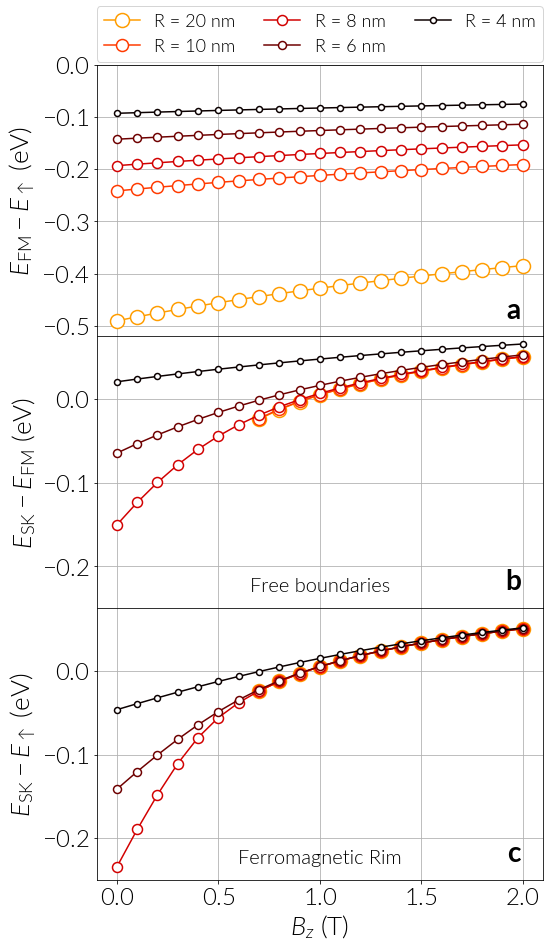

In [79]:
Rs = [20, 10, 8, 6, 4]
cm_subsection = np.linspace(0.4, 1, len(Rs)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

f, axs = plt.subplots(ncols=1, nrows=3, figsize=(8, 24 / 1.6), sharex=True)

for i, R in enumerate(Rs):
    
    sim = create_simulation(R, B * 1e-3, pin_bs=None)
    # n_atoms = len(sim.mesh.coordinates[:, 0][sim.mu_s / C.mu_B > 1e-5])
    # n_atoms = 1
    
    # Energy FM state minus Energy saturated state 
    axs[0].plot(hexagons_fm_up[R][:, 0], hexagons_fm_up[R][:, 1] / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms)
                label=r'R = {} nm'.format(R),
                markerfacecolor='w', ms=14 - 2 * i, mew=1.5
                )
    
    if R >= 10:
        start = 7
    else:
        start = 0
    
    # Energy of skyrmions with respect to FM state in islands with free boundaries
    axs[1].plot(hexagons_fm_up[R][start:, 0],
                (hexagons_sk_down[R][start:, 1] - hexagons_fm_up[R][start:, 1]) / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='w', ms=14 - 2 * i, mew=1.5
                )
    # Energy of skyrmions with respect to FM state in islands with a FM rim
    axs[2].plot(hexagons_sk_down_pinbs[R][start:, 0],
                (hexagons_sk_down_pinbs[R][start:, 1]) / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='w', ms=14 - 2 * i, mew=1.5
                )
    # axs[1].yaxis.tick_right()
    
axs[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(0, 1.01, 1.0, 1),
              mode='expand', borderaxespad=0., fontsize=18,
              )

axs[0].set_ylabel(r'$E_{\mathrm{FM}} - E_{\uparrow}\,\,\mathrm{(eV)}$')

axs[1].set_ylabel(r'$E_{\mathrm{SK}} - E_{\mathrm{FM}}\,\,\mathrm{(eV)}$')

axs[2].set_ylabel(r'$E_{\mathrm{SK}} - E_{\uparrow}\,\,\mathrm{(eV)}$')
axs[2].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
    
axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_ylim(-0.52, 0.0)
axs[0].set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5])

axs[1].set_ylim(-0.25, 0.075)
axs[2].set_ylim(-0.25, 0.075)

for i, l in enumerate(['a', 'b', 'c']):
    axs[i].text(0.95, 0.05, l, horizontalalignment='right',
                verticalalignment='bottom', transform=axs[i].transAxes, 
                fontsize=28, fontweight='bold')
    
axs[1].text(0.5, 0.05, 'Free boundaries', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[1].transAxes, 
            fontsize=20, fontweight='light')
axs[2].text(0.5, 0.05, 'Ferromagnetic Rim', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[2].transAxes, 
            fontsize=20, fontweight='light')
    
plt.subplots_adjust(hspace=0)

plt.savefig('hexagons_size_variation_FM-energy_sk-energy.pdf',
            bbox_inches='tight')

# Ferromagnetic state and target state energy

The same plot we did for skyrmions before but now using the energy of target states:

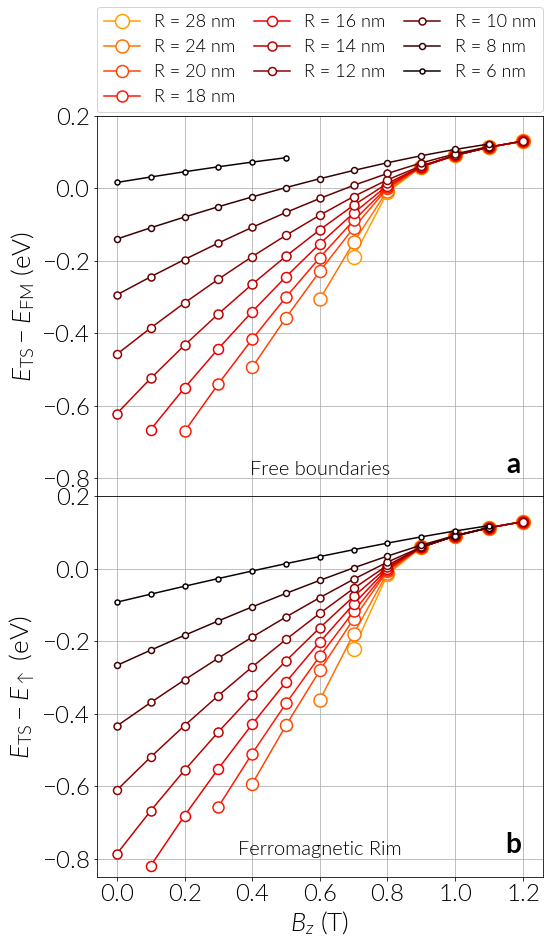

In [120]:
Rs = [28, 24, 20, 18, 16, 14, 12, 10, 8, 6]
cm_subsection = np.linspace(0.4, 1, len(Rs)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

f, axs = plt.subplots(ncols=1, nrows=2, figsize=(8, 14), sharex=True)

for i, R in enumerate(Rs):
    
    sim = create_simulation(R, B * 1e-3, pin_bs=None)
    # n_atoms = len(sim.mesh.coordinates[:, 0][sim.mu_s / C.mu_B > 1e-5])
    # n_atoms = 1
    
    start = 0
    stop = 13
    
    # Target states are not stabilised in certain ranges of applied fields, and
    # this varies for different island sizes. THus we filter the data points
    # with these variables:
    if R == 6:
        stop = 6
    elif R == 8 or R == 10:
        stop = 12
    elif R == 16:
        start = 1
    elif R ==18:
        start = 2
    elif R ==20:
        start = 4
    elif R ==24:
        start = 6
    elif R ==28:
        start = 7
        
    # Target state energy in islands with free boundaries
    axs[0].plot(hexagons_fm_up[R][start:stop, 0],
                (hexagons_tgt_st[R][start:stop, 1] - hexagons_fm_up[R][start:stop, 1]) / 1, 'o-', 
                color=cm_colors[i],
                label=r'R = {} nm'.format(R),
                markerfacecolor='w', ms=14 - 1 * i, mew=1.5
                )
    
    # FM Rim --------------------------------------------------------------
    
    if R == 6:
        stop = 12
    elif R == 16:
        start = 1
    elif R ==18:
        start = 3
    elif R ==20:
        start = 4
    elif R ==24:
        start = 6
    elif R ==28:
        start = 7
    
    axs[1].plot(hexagons_tgt_st_pinbs[R][start:stop, 0],
                hexagons_tgt_st_pinbs[R][start:stop, 1] / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='w', ms=14 - 1 * i, mew=1.5
                )
    # ---------------------------------------------------------------------

axs[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(0, 1.01, 1.0, 1),
              mode='expand', borderaxespad=0., fontsize=18,
              )
    
axs[0].set_ylabel(r'$E_{\mathrm{TS}} - E_{\mathrm{FM}}\,\,\mathrm{(eV)}$')

axs[1].set_ylabel(r'$E_{\mathrm{TS}} - E_{\uparrow}\,\,\mathrm{(eV)}$')
axs[1].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
    
axs[0].grid()
axs[1].grid()

axs[0].set_ylim(-0.85, 0.2)
axs[1].set_ylim(-0.85, 0.2)

axs[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

for i, l in enumerate(['a', 'b']):
    axs[i].text(0.95, 0.05, l, horizontalalignment='right',
                verticalalignment='bottom', transform=axs[i].transAxes, 
                fontsize=28, fontweight='bold')
    
axs[0].text(0.5, 0.05, 'Free boundaries', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[0].transAxes, 
            fontsize=20, fontweight='light')
axs[1].text(0.5, 0.05, 'Ferromagnetic Rim', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[1].transAxes, 
            fontsize=20, fontweight='light')
    
plt.subplots_adjust(hspace=0)

plt.savefig('hexagons_size_variation_tgt-state-energy.pdf',
            bbox_inches='tight')

# Combined plots

Here we combine in the same plot the results of skyrmion and target state energies in islands with different boundary conditions:

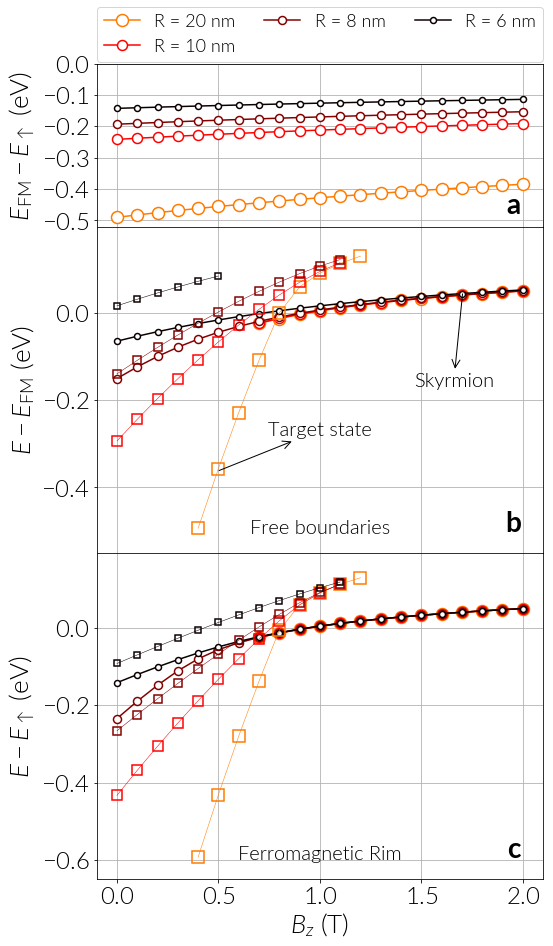

In [60]:
Rs = [20, 10, 8, 6]
cm_subsection = np.linspace(0.45, 1, len(Rs)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

f, axs = plt.subplots(ncols=1, nrows=3, figsize=(8, 24 / 1.6), sharex=True, gridspec_kw={'height_ratios': [0.5, 1, 1]})

for i, R in enumerate(Rs):
    
    sim = create_simulation(R, B * 1e-3, pin_bs=None)
    # n_atoms = len(sim.mesh.coordinates[:, 0][sim.mu_s / C.mu_B > 1e-5])
    # n_atoms = 1

    # FERROMAGNETIC STATE ENERGY ---------------------------------------------
    
    # Energy FM state minus Energy saturated state 
    axs[0].plot(hexagons_fm_up[R][:, 0], hexagons_fm_up[R][:, 1] / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms)
                label=r'R = {} nm'.format(R),
                markerfacecolor='w', ms=12 - 2 * i, mew=1.5
                )
    
    if R >= 10:
        start = 7
    else:
        start = 0
    
    # SKYRMIONS ---------------------------------------------

    # Free boundaries
    axs[1].plot(hexagons_fm_up[R][start:, 0],
                (hexagons_sk_down[R][start:, 1] - hexagons_fm_up[R][start:, 1]) / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='w', ms=12 - 2 * i, mew=1.5
                )
    
    # Ferromagnetic rim
    axs[2].plot(hexagons_sk_down_pinbs[R][start:, 0],
                (hexagons_sk_down_pinbs[R][start:, 1]) / 1, 'o-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='w', ms=12 - 2 * i, mew=1.5
                )
    # axs[1].yaxis.tick_right()

# TARGET STATE ---------------------------------------------------------

# Rs = [20, 18, 16, 14, 12, 10, 8, 6]
# Rs = [20, 10, 8, 6]
# cm_subsection = np.linspace(0.5, 1, len(Rs)) 
# cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection]

for i, R in enumerate(Rs):
   
    start = 0
    stop = 13
    
    if R == 6:
        stop = 6
    elif R == 8 or R == 10:
        stop = 12
    elif R == 16:
        start = 1
    elif R ==18:
        start = 2
    elif R ==20:
        start = 4
    elif R ==24:
        start = 6
    elif R ==28:
        start = 7
        
    # Free boundaries -----------------------------------------------------
    axs[1].plot(hexagons_fm_up[R][start:stop, 0],
                (hexagons_tgt_st[R][start:stop, 1] - hexagons_fm_up[R][start:stop, 1]) / 1, 's-', 
                color=cm_colors[i],
                label=r'R = {} nm'.format(R),
                markerfacecolor='None', ms=12 - 2 * i, mew=1.5,
                linewidth=0.5
                )
    
    # FM Rim --------------------------------------------------------------
    
    if R == 6:
        stop = 12
    elif R == 16:
        start = 1
    elif R ==18:
        start = 3
    elif R ==20:
        start = 4
    elif R ==24:
        start = 6
    elif R ==28:
        start = 7
    
    axs[2].plot(hexagons_tgt_st_pinbs[R][start:stop, 0],
                hexagons_tgt_st_pinbs[R][start:stop, 1] / 1, 's-', 
                color=cm_colors[i],
                # label=r'R = {} nm ({} spins)'.format(R, n_atoms),
                markerfacecolor='None', ms=12 - 2 * i, mew=1.5,
                linewidth=0.5
                )
    
# -----------------------------------------------------------------------
# LABELS and LEGENDS

axs[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(0, 1.01, 1.0, 1),
              mode='expand', borderaxespad=0., fontsize=18,
              )

axs[0].set_ylabel(r'$E_{\mathrm{FM}} - E_{\uparrow}\,\,\mathrm{(eV)}$')

axs[1].set_ylabel(r'$E - E_{\mathrm{FM}}\,\,\mathrm{(eV)}$')

axs[2].set_ylabel(r'$E - E_{\uparrow}\,\,\mathrm{(eV)}$')
axs[2].set_xlabel(r'$B_{z}\,\,(\mathrm{T})$')
    
axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_ylim(-0.52, 0.0)
axs[0].set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5])

axs[1].set_ylim(-0.55, 0.198)
axs[2].set_ylim(-0.65, 0.195)

for i, l in enumerate(['a', 'b', 'c']):
    axs[i].text(0.95, 0.05, l, horizontalalignment='right',
                verticalalignment='bottom', transform=axs[i].transAxes, 
                fontsize=28, fontweight='bold')
    
axs[1].text(0.5, 0.05, 'Free boundaries', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[1].transAxes, 
            fontsize=20, fontweight='light')
axs[2].text(0.5, 0.05, 'Ferromagnetic Rim', horizontalalignment='center',
            verticalalignment='bottom', transform=axs[2].transAxes, 
            fontsize=20, fontweight='light')
    
# Labels for the configuration: sk or tgt state:
axs[1].annotate('Skyrmion', 
                (0.82, 0.8), xycoords='axes fraction',
                xytext=(0.8, 0.5), textcoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='bottom',
                arrowprops=dict(arrowstyle="<-"),
                # transform=axs[1].transAxes, 
                fontsize=20, fontweight='light'
                )

axs[1].annotate('Target state', 
                (0.27, 0.25), xycoords='axes fraction',
                xytext=(0.5, 0.35), textcoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='bottom',
                arrowprops=dict(arrowstyle="<-"),
                # transform=axs[1].transAxes, 
                fontsize=20, fontweight='light'
                )
    
plt.subplots_adjust(hspace=0)

plt.savefig('hexagons_size_variation_FM-energy_tgt-state_sk_energy.pdf',
            bbox_inches='tight')